In [187]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
import geopandas as gp
import jenkspy as jp

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy.signal import argrelextrema

from PreProcessing import PreProcessingShapefiles

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#np.set_printoptions(threshold=sys.maxsize)

# Read dataset

In [5]:
# Read dataset
df = pd.read_csv(r'D:\Google Drive\University of York courses\Independent Research Proposal\dissertation\data\preprocessed\data_hotspots_forecasting_final.csv')
df.set_index('unique_id', inplace=True)
df["unique_id_time"] = pd.to_datetime(df["unique_id_time"])
print("Rows: ", df.shape[0])
print("Features: " + str(df.shape[1]) + "\n")
df.head(10)

Rows:  63525
Features: 41



,key_neighb,unique_id_time,crime_count_t,crime_count_t+1,women_vic_t,women_vic_t+1,men_vic_t,men_vic_t+1,less_18_vic_t,less_18_vic_t+1,18_to_29_vic_t,18_to_29_vic_t+1,30_to_39_vic_t,30_to_39_vic_t+1,40_to_49_vic_t,40_to_49_vic_t+1,50_to_59_vic_t,50_to_59_vic_t+1,more_60_vic_t,more_60_vic_t+1,cablebus_s,commer_ven,health_cen,metro_sta,pmarkets,pparking,hospitals,train_sta,trolebus_s,cablebus_l,ptransp_ro,main_roads,metro_line,rtp_lines,train_line,trolebus_l,centres_va,be_schools,commercial,industrial,service_un
unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019202-001,02-001,2019-02-01,0.0,1,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43
2019302-001,02-001,2019-03-01,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43
2019402-001,02-001,2019-04-01,0.0,1,0.0,0,0.0,1,0.0,0,0.0,1,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43
2019502-001,02-001,2019-05-01,1.0,1,0.0,0,1.0,2,0.0,1,1.0,0,0.0,1,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43
2019602-001,02-001,2019-06-01,1.0,0,0.0,0,2.0,0,1.0,0,0.0,0,1.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43
2019702-001,02-001,2019-07-01,0.0,1,0.0,0,0.0,1,0.0,0,0.0,1,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43
2019802-001,02-001,2019-08-01,1.0,0,0.0,0,1.0,0,0.0,0,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43
2019902-001,02-001,2019-09-01,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43
20191002-001,02-001,2019-10-01,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,9,1,0,6,0,1,0,1,63,10,43


In [6]:
pivot_df = pd.pivot_table(df, index='key_neighb', values = ['crime_count_t+1', 'crime_count_t', 'women_vic_t+1', 'men_vic_t+1', 
                                                           'less_18_vic_t+1', '18_to_29_vic_t+1', '30_to_39_vic_t+1', 
                                                            '40_to_49_vic_t+1', '50_to_59_vic_t+1', 'more_60_vic_t+1',
                                                           'cablebus_s', 'commer_ven', 'health_cen', 'metro_sta', 'pmarkets', 
                                                            'pparking', 'hospitals', 'train_sta', 'trolebus_s', 'cablebus_l', 
                                                            'ptransp_ro', 'main_roads', 'metro_line', 'rtp_lines', 'train_line', 
                                                            'trolebus_l', 'centres_va', 'be_schools', 'commercial', 'industrial', 
                                                            'service_un'], aggfunc=np.median)
print(pivot_df.shape)
pivot_df.head()


(1815, 31)


,18_to_29_vic_t+1,30_to_39_vic_t+1,40_to_49_vic_t+1,50_to_59_vic_t+1,be_schools,cablebus_l,cablebus_s,centres_va,commer_ven,commercial,crime_count_t,crime_count_t+1,health_cen,hospitals,industrial,less_18_vic_t+1,main_roads,men_vic_t+1,metro_line,metro_sta,more_60_vic_t+1,pmarkets,pparking,ptransp_ro,rtp_lines,service_un,train_line,train_sta,trolebus_l,trolebus_s,women_vic_t+1
key_neighb,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
02-001,0,0,0,0,1,0,0,0,0,63,1.0,1,0,0,10,0,1,0,0,0,0,0,0,9,6,43,0,0,1,2,0
02-002,0,0,0,0,2,0,0,0,0,52,1.0,1,0,0,13,0,1,1,0,0,0,0,0,2,4,56,0,0,1,0,0
02-003,0,0,0,0,0,0,0,0,0,20,1.0,1,0,0,4,0,1,0,0,0,0,0,0,8,1,18,0,0,0,0,0
02-005,0,0,0,0,3,0,0,0,0,53,2.0,2,0,0,10,1,0,2,1,1,0,0,2,30,6,89,0,0,0,0,0
02-006,0,0,0,0,4,0,0,0,0,164,2.0,2,0,1,22,0,0,1,0,0,0,1,0,6,3,88,0,0,0,0,0


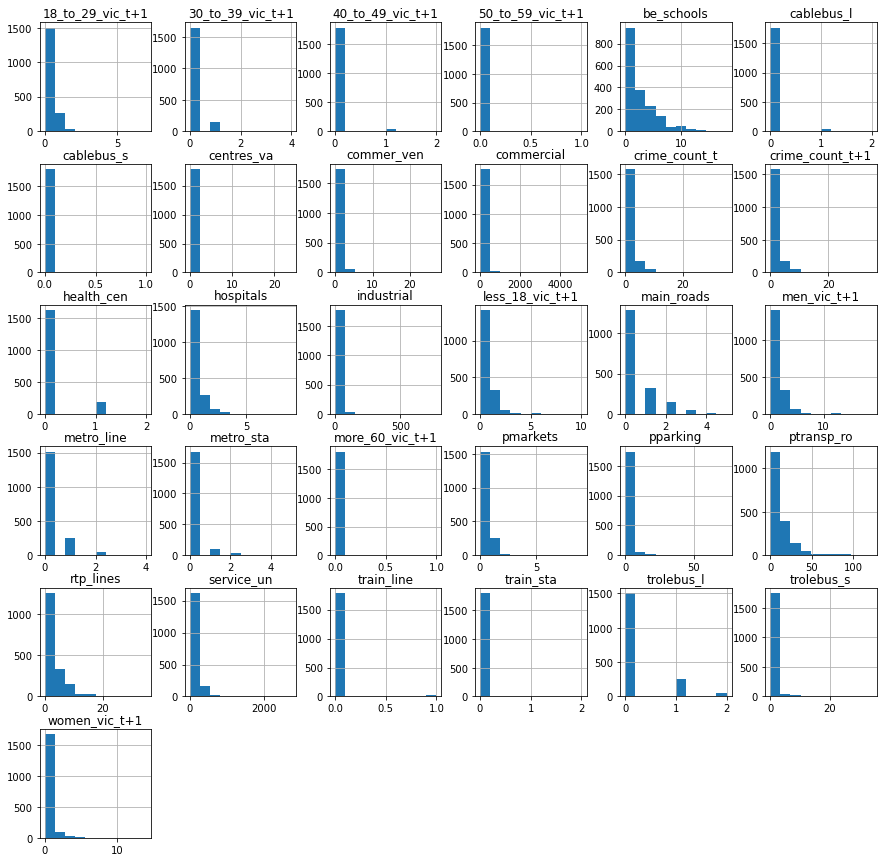

In [7]:
pivot_df.hist(figsize=(15,15))
plt.show()

In [11]:
X = pivot_df[['crime_count_t+1']].values
print(X.shape)

(1815, 1)


# Read neighborhoods shapefile

In [87]:
path = r'D:\Google Drive\University of York courses\Independent Research Proposal\dissertation\data\raw\shapefiles\neighborhoods'
neighborhoods_shp = gp.read_file(path + '/mgpc_2019.shp')

In [88]:
pps = PreProcessingShapefiles()
rp_neighborhoods_shp = pps.reprojectShapefiles([neighborhoods_shp])
rp_neighborhoods_shp[0].crs

All shapefiles were successfully reprojected.


<Derived Projected CRS: EPSG:32614>
Name: WGS 84 / UTM zone 14N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 102°W and 96°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Manitoba; Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-102.0, 0.0, -96.0, 84.0)
Coordinate Operation:
- name: UTM zone 14N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [89]:
nshp = rp_neighborhoods_shp[0]
key_nshp = nshp.copy()
key_nshp = key_nshp[['CVEUT', 'geometry']]
key_nshp.columns = ['key_n', 'geometry']
key_nshp['key_n'] = key_nshp['key_n'].astype('string')
key_nshp.head()

,key_n,geometry
0,02-001,"POLYGON ((483311.618 2153254.848, 483332.006 2..."
1,02-002,"POLYGON ((484406.956 2153012.331, 484401.132 2..."
2,02-005,"POLYGON ((480013.755 2153003.618, 480026.649 2..."
3,02-006,"POLYGON ((484061.118 2152622.284, 484061.678 2..."
4,02-007,"POLYGON ((480104.707 2154525.214, 480118.178 2..."


In [90]:
key_nshp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   key_n     1815 non-null   string  
 1   geometry  1815 non-null   geometry
dtypes: geometry(1), string(1)
memory usage: 28.5 KB


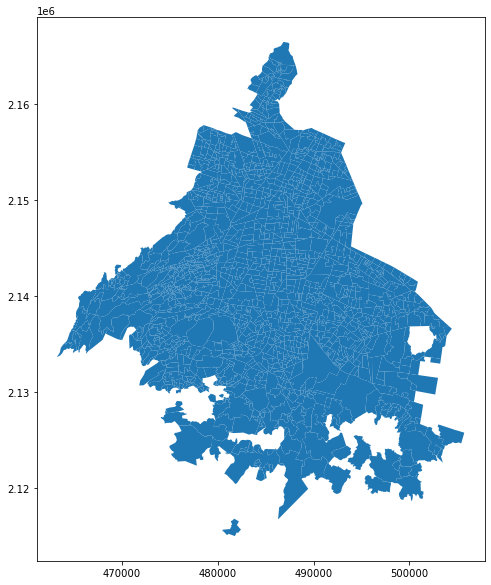

In [91]:
key_nshp.plot(figsize=(10,10))
plt.show()

# Min-max normalization

In [45]:
# Min-max normalization
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)


# Yeo-Johnson power transform

In [46]:
pt_yj = PowerTransformer(method='yeo-johnson')
X_pt = pt_yj.fit_transform(X_norm)

# Kernel density estimation

## Bandwidth

Bandwidth:  1
Minima: [14.69387755 19.28571429 24.79591837 31.2244898 ]
Maxima: [ 0.91836735 17.44897959 21.12244898 29.3877551  33.97959184]
Bandwidth:  2
Minima: [24.79591837]
Maxima: [ 0.91836735 33.97959184]
Bandwidth:  3
Minima: [25.71428571]
Maxima: [ 0.91836735 33.06122449]
Bandwidth:  4
Minima: [26.63265306]
Maxima: [ 0.91836735 32.14285714]
Bandwidth:  5
Minima: [28.46938776]
Maxima: [ 0.91836735 31.2244898 ]
Bandwidth:  6
Minima: []
Maxima: [0.91836735]
Bandwidth:  7
Minima: []
Maxima: [0.91836735]
Bandwidth:  8
Minima: []
Maxima: [0.91836735]
Bandwidth:  9
Minima: []
Maxima: [1.83673469]


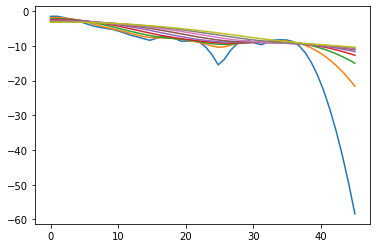

In [51]:
kernel = 'gaussian'
list_bw = [x for x in range(1, 10)]
for bw in list_bw:
    print('Bandwidth: ', bw)
    kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(X)
    s = np.linspace(0,45)
    e = kde.score_samples(s.reshape(-1,1))
    plt.plot(s, e)
    
    mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
    print("Minima:", s[mi])
    print("Maxima:", s[ma])


In [70]:
np.linspace(0.1, 10, 20)

array([ 0.1       ,  0.62105263,  1.14210526,  1.66315789,  2.18421053,
        2.70526316,  3.22631579,  3.74736842,  4.26842105,  4.78947368,
        5.31052632,  5.83157895,  6.35263158,  6.87368421,  7.39473684,
        7.91578947,  8.43684211,  8.95789474,  9.47894737, 10.        ])

In [150]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

kernel = 'gaussian'

grid = GridSearchCV(KernelDensity(kernel = kernel),{'bandwidth': np.linspace(0.1, 10, 30)}, cv = 5)
grid.fit(X)
best_bw = grid.best_estimator_.bandwidth
print("bandwidth selected : ", best_bw)



bandwidth selected :  1.4655172413793105


## Train

Minima: [14.69387755 24.79591837 31.2244898 ]
Maxima: [ 0.91836735 16.53061224 29.3877551  33.97959184]


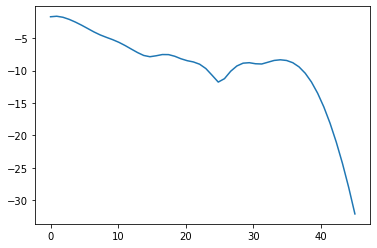

In [151]:
kde = KernelDensity(kernel=kernel, bandwidth=best_bw).fit(X)
s = np.linspace(0,45)
e = kde.score_samples(s.reshape(-1,1))
plt.plot(s, e)

mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

In [157]:
cluster1 = list(X[X < s[mi][0]])
cluster2 = list(X[(X >= s[mi][0]) * (X <= s[mi][1])])
cluster3 = list(X[(X >= s[mi][1]) * (X <= s[mi][2])])
cluster4 = list(X[X >= s[mi][2]])
print("cluster 1: ", len(cluster1))
print("cluster 2: ", len(cluster2))
print("cluster 3: ", len(cluster3))
print("cluster 4: ", len(cluster4))

cluster 1:  1807
cluster 2:  5
cluster 3:  1
cluster 4:  2


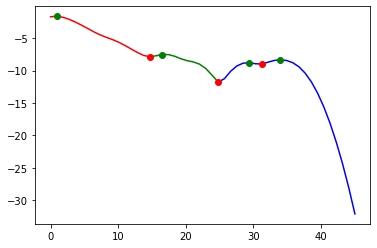

In [74]:
plt.plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

In [184]:
df_kde_labeled = pivot_df[['crime_count_t+1']].reset_index()
df_kde_labeled.loc[df_kde_labeled['crime_count_t+1'].isin(cluster1), 'cluster'] = 'Cluster 1'
df_kde_labeled.loc[df_kde_labeled['crime_count_t+1'].isin(cluster2), 'cluster'] = 'Cluster 2'
df_kde_labeled.loc[df_kde_labeled['crime_count_t+1'].isin(cluster3), 'cluster'] = 'Cluster 3'
df_kde_labeled.loc[df_kde_labeled['crime_count_t+1'].isin(cluster4), 'cluster'] = 'Cluster 4'

df_kde_labeled.columns = ['key_n', 'crime_count', 'cluster']

df_kde_labeled.head()

,key_n,crime_count,cluster
0,02-001,1,Cluster 1
1,02-002,1,Cluster 1
2,02-003,1,Cluster 1
3,02-005,2,Cluster 1
4,02-006,2,Cluster 1


## Merge and map

In [167]:
kde_clusters_map = key_nshp.merge(df_kde_labeled, on='key_n', how='left')
kde_clusters_map.head()

,key_n,geometry,crime_count,cluster
0,02-001,"POLYGON ((483311.618 2153254.848, 483332.006 2...",1,Cluster 1
1,02-002,"POLYGON ((484406.956 2153012.331, 484401.132 2...",1,Cluster 1
2,02-005,"POLYGON ((480013.755 2153003.618, 480026.649 2...",2,Cluster 1
3,02-006,"POLYGON ((484061.118 2152622.284, 484061.678 2...",2,Cluster 1
4,02-007,"POLYGON ((480104.707 2154525.214, 480118.178 2...",6,Cluster 1


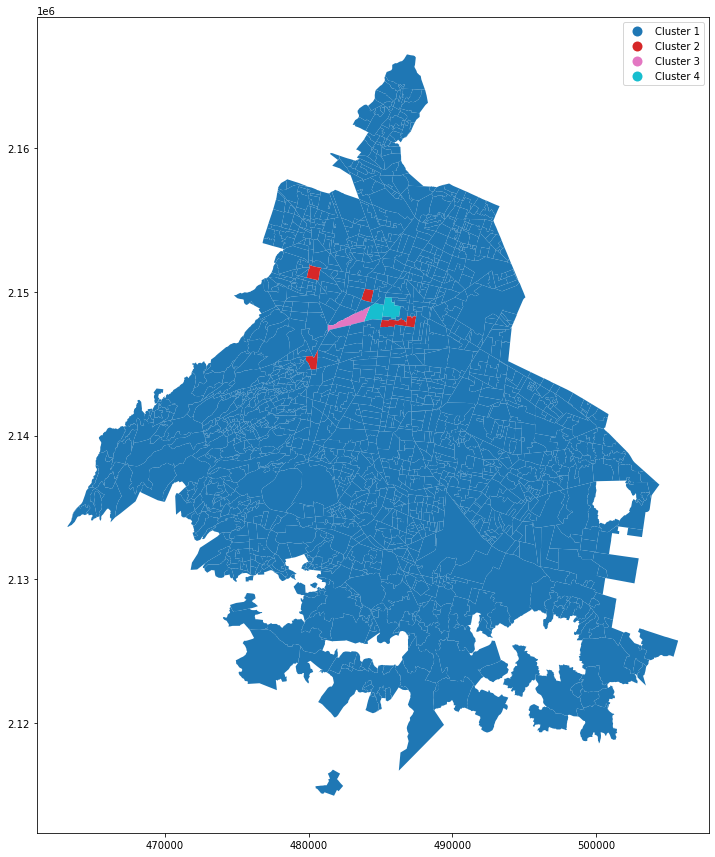

In [214]:
kde_clusters_map.plot("cluster", legend=True, cmap='tab10', figsize=(15,15))
plt.show()

## Silouhette score

In [185]:
silhouette_score(X, df_kde_labeled[['cluster']].values)

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8738146614003587

## Interpretation of results

In [169]:
from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])


In [173]:
cluster_report(df_kde_labeled.iloc[:,1:-1], df_kde_labeled['cluster'].values, min_samples_leaf=50, pruning_level=0.01)

,class_name,instance_count,rule_list
0,Cluster 1,1807,[0.9955922865013774] ALL
1,Cluster 2,5,NaN
3,Cluster 3,1,NaN
2,Cluster 4,2,NaN


In [174]:
# Calculate the mean by group
kde_gb = df_kde_labeled.iloc[:, 1:].groupby('cluster')[['crime_count']].median()
# Show the table transposed (so it's not too wide)
kde_gb.T


cluster,Cluster 1,Cluster 2,Cluster 3,Cluster 4
crime_count,1.0,17.0,29.0,34.0


In [175]:
df_kde_labeled.iloc[:, 1:].groupby('cluster')[['crime_count']].describe()

crime_count                                                   
                count       mean       std   min   25%   50%   75%   max
cluster                                                                 
Cluster 1      1807.0   1.459325  1.894616   0.0   0.0   1.0   2.0  13.0
Cluster 2         5.0  17.800000  1.923538  16.0  17.0  17.0  18.0  21.0
Cluster 3         1.0  29.000000       NaN  29.0  29.0  29.0  29.0  29.0
Cluster 4         2.0  34.000000  1.414214  33.0  33.5  34.0  34.5  35.0

# K-means (1-D)

In [77]:
X_pt.shape

(1815, 1)

## Train

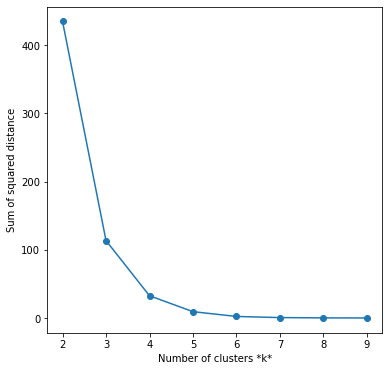

In [123]:
list_k = list(range(2, 10))
sse = []

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_pt)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [144]:
cluster_count = 4
kmeans = KMeans(n_clusters=cluster_count, max_iter=1000, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pt)
centroids = kmeans.cluster_centers_

## Plot clusters

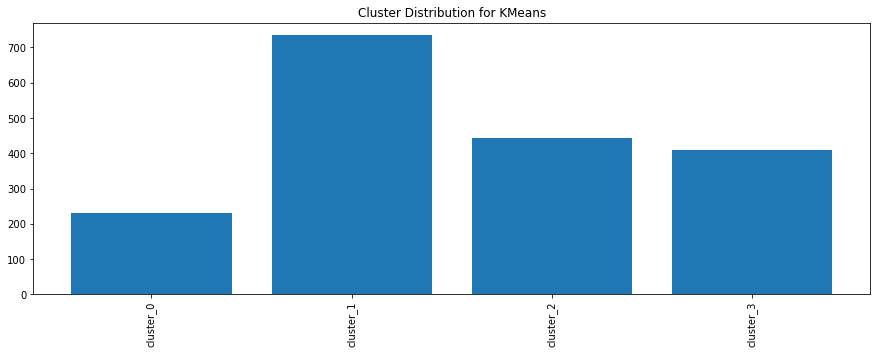

In [145]:
cluster_c = [len(kmeans_labels[kmeans_labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.xticks(rotation = 90)
plt.show()


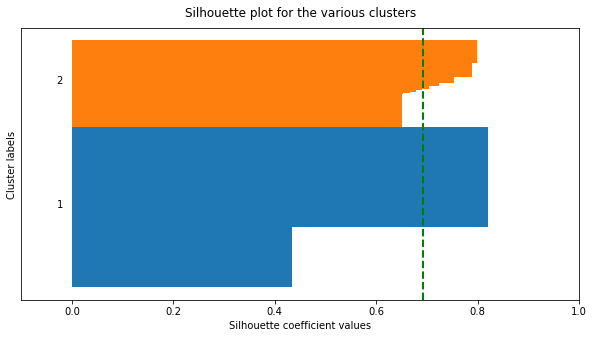

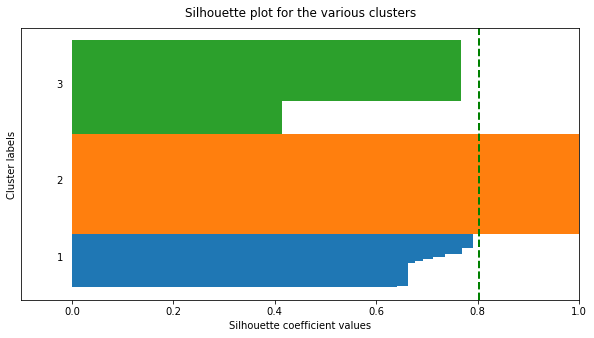

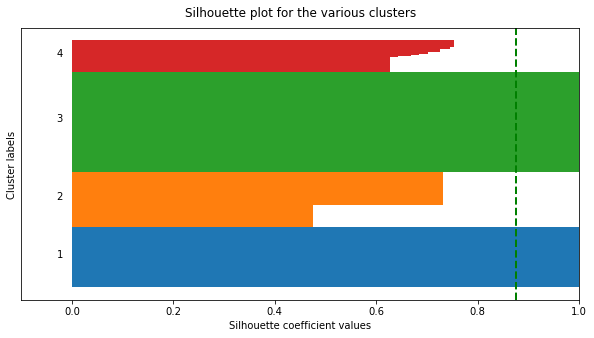

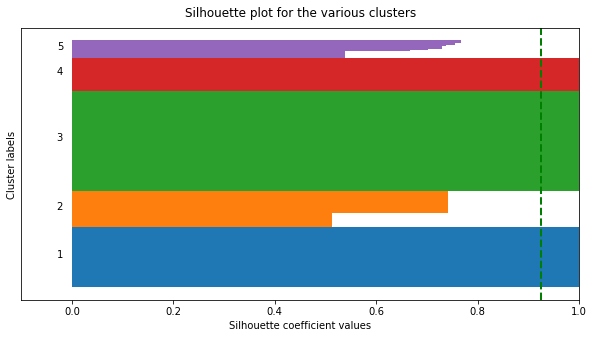

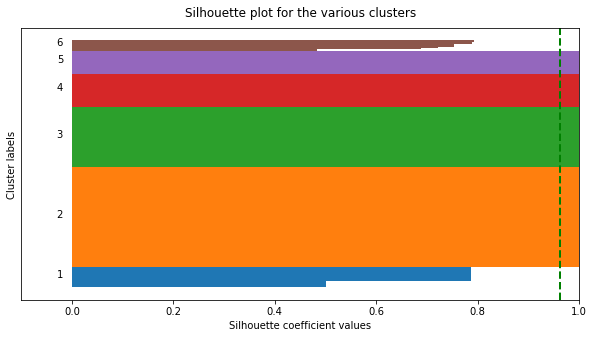

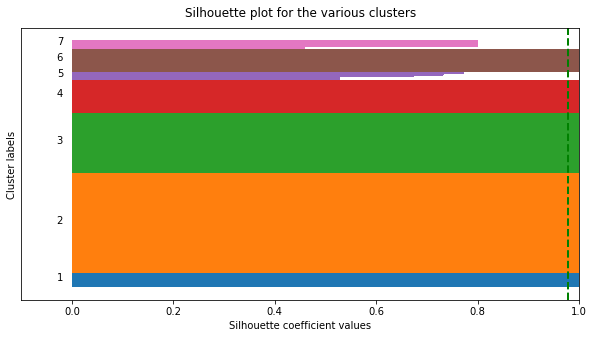

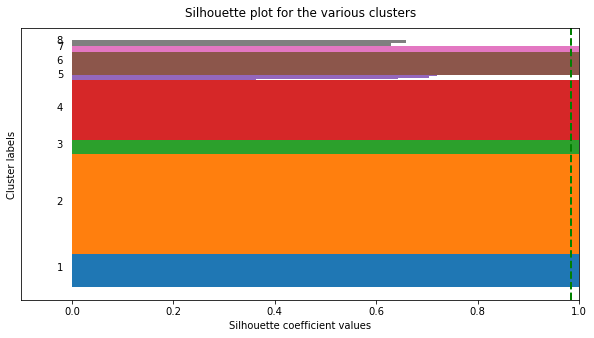

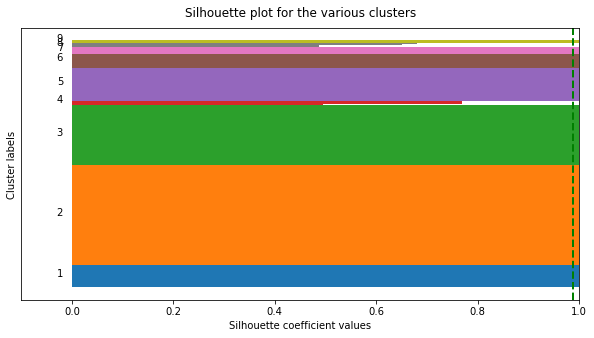

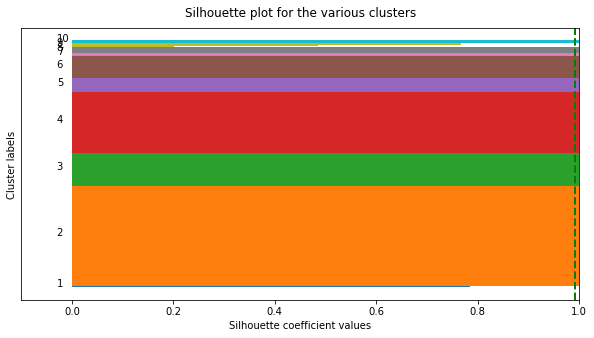

In [83]:
for i, k in enumerate([2, 3, 4, 5, 6, 7, 8, 9, 10]):
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(10, 5)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_pt)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_pt, labels)


    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);

In [146]:
df_X = pivot_df[['crime_count_t+1']].reset_index()

df_kmeans_labels = pd.DataFrame(kmeans_labels)
df_kmeans_labels.columns = ['cluster']

df_km_labeled = pd.concat([df_X, df_kmeans_labels], axis=1)
df_km_labeled.columns = ['key_n', 'crime_count', 'cluster']
print(df_km_labeled.shape)
df_km_labeled.head()

(1815, 3)


,key_n,crime_count,cluster
0,02-001,1,2
1,02-002,1,2
2,02-003,1,2
3,02-005,2,3
4,02-006,2,3


## Merge and map

In [147]:
km_clusters_map = key_nshp.merge(df_km_labeled, on='key_n', how='left')
km_clusters_map.head()

,key_n,geometry,crime_count,cluster
0,02-001,"POLYGON ((483311.618 2153254.848, 483332.006 2...",1,2
1,02-002,"POLYGON ((484406.956 2153012.331, 484401.132 2...",1,2
2,02-005,"POLYGON ((480013.755 2153003.618, 480026.649 2...",2,3
3,02-006,"POLYGON ((484061.118 2152622.284, 484061.678 2...",2,3
4,02-007,"POLYGON ((480104.707 2154525.214, 480118.178 2...",6,0


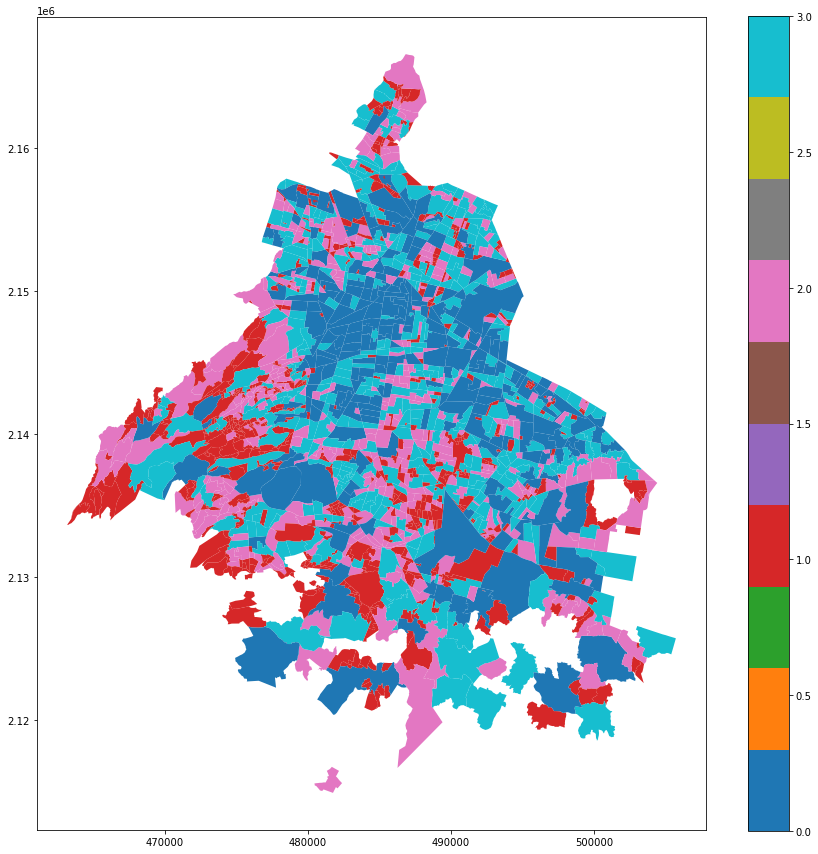

In [148]:
km_clusters_map.plot("cluster", legend=True, cmap='tab10', figsize=(15,15))
plt.show()

## Silouhette score

In [94]:
from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])


In [97]:
for k in [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]:
    cluster_count = k
    km = KMeans(n_clusters=cluster_count, max_iter=5000)
    km_labels = km.fit_predict(X_pt)
    print('Silouhette score for k=' + str(k) + ': ' + str(silhouette_score(X_pt, km_labels)))
    print()
    
    cluster_report(df_km_labeled.iloc[:, 1:-1], km_labels, min_samples_leaf=50, pruning_level=0.01)

Silouhette score for k=2: 0.6922919040220039



,class_name,instance_count,rule_list
0,0,1176,[1.0] (crime_count <= 1.5)
1,1,639,[1.0] (crime_count > 1.5)


Silouhette score for k=3: 0.8027296710868651



,class_name,instance_count,rule_list
1,0,685,[1.0] (crime_count > 0.5) and (crime_count <= 2.5)
0,1,734,[1.0] (crime_count <= 0.5)
2,2,396,[1.0] (crime_count > 0.5) and (crime_count > 2.5)


Silouhette score for k=4: 0.8756186435083666



,class_name,instance_count,rule_list
2,0,408,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count <= 3.5)
0,1,734,[1.0] (crime_count <= 0.5)
1,2,442,[1.0] (crime_count > 0.5) and (crime_count <= 1.5)
3,3,231,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 3.5)


Silouhette score for k=5: 0.9250554582483553



,class_name,instance_count,rule_list
3,0,243,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count <= 2.5)
0,1,734,[1.0] (crime_count <= 0.5)
1,2,442,[1.0] (crime_count > 0.5) and (crime_count <= 1.5)
2,3,268,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count <= 4.5)
4,4,128,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 4.5)


Silouhette score for k=6: 0.9612939279218171



,class_name,instance_count,rule_list
1,0,442,[1.0] (crime_count > 0.5) and (crime_count <= 1.5)
3,1,165,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count <= 3.5)
0,2,734,[1.0] (crime_count <= 0.5)
2,3,243,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count <= 2.5)
4,4,150,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count <= 5.5)
5,5,81,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count > 5.5)


Silouhette score for k=7: 0.9777065021367136



,class_name,instance_count,rule_list
0,0,734,[1.0] (crime_count <= 0.5)
3,1,165,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count <= 3.5)
1,2,442,[1.0] (crime_count > 0.5) and (crime_count <= 1.5)
6,3,62,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count > 4.5) and (crime_count > 6.5)
2,4,243,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count <= 2.5)
4,5,103,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count <= 4.5)
5,6,66,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count > 4.5) and (crime_count <= 6.5)


Silouhette score for k=8: 0.9834179236844776



,class_name,instance_count,rule_list
6,0,41,[0.6612903225806451] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count > 4.5) and (crime_count > 6.5)
0,1,734,[1.0] (crime_count <= 0.5)
1,2,442,[1.0] (crime_count > 0.5) and (crime_count <= 1.5)
3,3,165,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count <= 3.5)
2,4,243,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count <= 2.5)
4,5,103,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count <= 4.5)
5,6,47,[0.7121212121212122] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count > 4.5) and (crime_count <= 6.5)
7,7,40,NaN


Silouhette score for k=9: 0.9874123883443466



,class_name,instance_count,rule_list
1,0,442,[1.0] (crime_count > 0.5) and (crime_count <= 1.5)
4,1,103,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count <= 4.5)
0,2,734,[1.0] (crime_count <= 0.5)
2,3,243,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count <= 2.5)
6,4,31,[0.5] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count > 4.5) and (crime_count > 6.5)
3,5,165,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count <= 3.5)
5,6,47,[0.7121212121212122] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count > 4.5) and (crime_count <= 6.5)
7,7,31,NaN
8,8,19,NaN


Silouhette score for k=10: 0.9916046364302097



,class_name,instance_count,rule_list
0,0,734,[1.0] (crime_count <= 0.5)
5,1,47,[0.7121212121212122] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count > 4.5) and (crime_count <= 6.5)
1,2,442,[1.0] (crime_count > 0.5) and (crime_count <= 1.5)
2,3,243,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count <= 2.5)
3,4,165,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count <= 3.5)
9,5,14,NaN
4,6,103,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count <= 4.5)
7,7,21,NaN
6,8,27,[0.43548387096774194] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count > 4.5) and (crime_count > 6.5)
8,9,19,NaN


Silouhette score for k=15: 0.9988334783954438



,class_name,instance_count,rule_list
1,0,442,[1.0] (crime_count > 0.5) and (crime_count <= 1.5)
4,1,103,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count <= 4.5)
0,2,734,[1.0] (crime_count <= 0.5)
2,3,243,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count <= 2.5)
8,4,14,NaN
3,5,165,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count <= 3.5)
5,6,47,[0.7121212121212122] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count > 4.5) and (crime_count <= 6.5)
6,7,21,[0.3387096774193548] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count > 4.5) and (crime_count > 6.5)
7,8,19,NaN
12,9,4,NaN


Silouhette score for k=20: 0.996694214876033



,class_name,instance_count,rule_list
6,0,21,[0.3387096774193548] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count > 4.5) and (crime_count > 6.5)
0,1,734,[1.0] (crime_count <= 0.5)
1,2,442,[1.0] (crime_count > 0.5) and (crime_count <= 1.5)
2,3,243,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count <= 2.5)
3,4,165,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count <= 3.5)
4,5,103,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count <= 4.5)
5,6,47,[0.7121212121212122] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count > 4.5) and (crime_count <= 6.5)
12,7,2,NaN
7,8,19,NaN
8,9,14,NaN


Silouhette score for k=25: 0.996694214876033



C:\Users\penny\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (20) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


,class_name,instance_count,rule_list
1,0,442,[1.0] (crime_count > 0.5) and (crime_count <= 1.5)
5,1,47,[0.7121212121212122] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count > 4.5) and (crime_count <= 6.5)
2,3,243,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count <= 2.5)
3,4,165,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count <= 3.5)
6,5,21,[0.3387096774193548] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count > 4.5) and (crime_count > 6.5)
19,7,1,NaN
8,8,14,NaN
7,9,19,NaN
9,10,10,NaN
10,11,4,NaN


Silouhette score for k=30: 0.996694214876033



C:\Users\penny\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (20) found smaller than n_clusters (30). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


,class_name,instance_count,rule_list
5,0,47,[0.7121212121212122] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count > 4.5) and (crime_count <= 6.5)
2,1,243,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count <= 2.5)
0,2,734,[1.0] (crime_count <= 0.5)
1,3,442,[1.0] (crime_count > 0.5) and (crime_count <= 1.5)
3,4,165,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count <= 3.5)
4,6,103,[1.0] (crime_count > 0.5) and (crime_count > 1.5) and (crime_count > 2.5) and (crime_count > 3.5) and (crime_count <= 4.5)
12,8,2,NaN
8,10,14,NaN
18,11,1,NaN
10,12,4,NaN


## Interpretation of results

In [104]:
# Calculate the mean by group
kmeans_gb = df_km_labeled.iloc[:, 1:].groupby('cluster')[['crime_count']].median()
# Show the table transposed (so it's not too wide)
kmeans_gb.T


cluster,0,1,2
crime_count,4.0,0.0,1.0


In [149]:
df_km_labeled.iloc[:, 1:].groupby('cluster')[['crime_count']].describe()

crime_count                                              
              count      mean       std  min  25%  50%  75%   max
cluster                                                          
0             231.0  6.060606  4.011479  4.0  4.0  5.0  7.0  35.0
1             734.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0
2             442.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0
3             408.0  2.404412  0.491380  2.0  2.0  2.0  3.0   3.0

# Jenks natural breaks

## Train

In [191]:
jnb = jp.JenksNaturalBreaks()

try:
    print(jnb.labels_)
    print(jnb.groups_)
    print(jnb.inner_breaks_)
except:
    pass

jnb.fit(X)
try:
    print(jnb.labels_, '\n')
    print(jnb.groups_, '\n')
    print(jnb.inner_breaks_, '\n')
except:
    pass

[1 1 1 ... 3 2 2] 

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0,

In [202]:
X_jnp_labeled = pivot_df[['crime_count_t+1']]
X_jnp_labeled['clusters'] = jnb.labels_
X_jnp_labeled = X_jnp_labeled.reset_index()
X_jnp_labeled.columns = ['key_n', 'crime_count', 'cluster']
print(X_jnp_labeled.shape)
X_jnp_labeled.head(3)

(1815, 3)


C:\Users\penny\AppData\Local\Temp/ipykernel_37268/1169852743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_jnp_labeled['clusters'] = jnb.labels_


,key_n,crime_count,cluster
0,02-001,1,1
1,02-002,1,1
2,02-003,1,1


In [196]:
X_jnp_labeled.clusters.unique()

array([1, 3, 2, 0, 4, 5])

## Merge and map

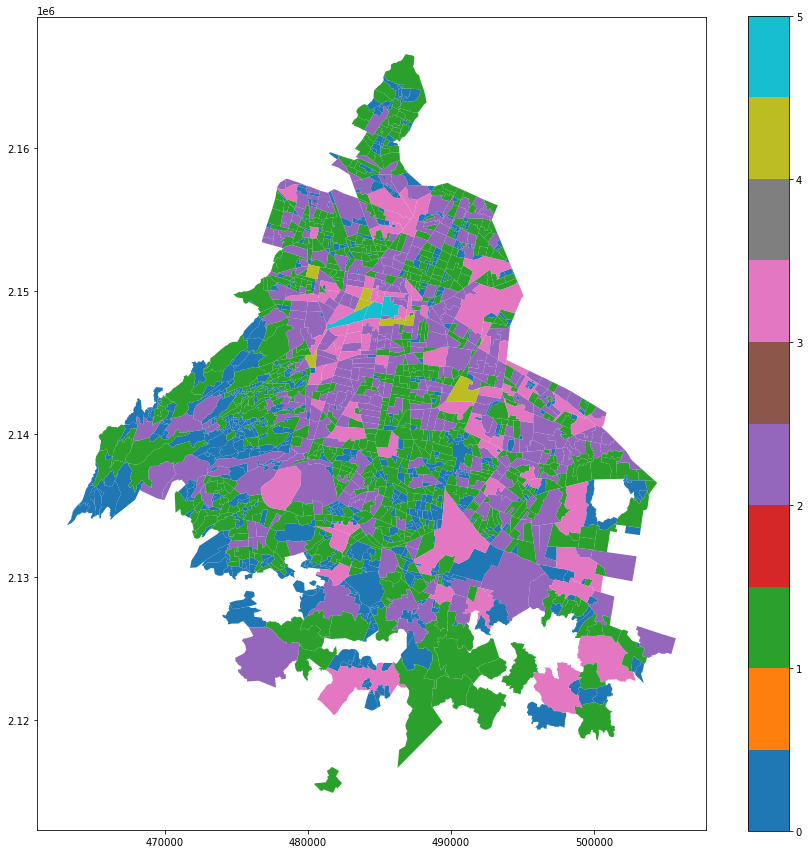

In [204]:
jnb_clusters_map.plot("cluster", legend=True, cmap='tab10', figsize=(15,15))
plt.show()

## Silouhette score

In [205]:
silhouette_score(X, X_jnp_labeled[['cluster']].values)

C:\Users\penny\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.7779658650121813

## Interpretation of results

In [206]:
from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])


In [208]:
cluster_report(X_jnp_labeled.iloc[:,1:-1], X_jnp_labeled['cluster'].values, min_samples_leaf=50, pruning_level=0.01)
print('Break points: ', [0.0, 2.0, 5.0, 11.0, 21.0]) 

,class_name,instance_count,rule_list
0,0,734,[1.0] (crime_count <= 0.5)
1,1,685,[1.0] (crime_count > 0.5) and (crime_count <= 2.5)
2,2,315,[1.0] (crime_count > 0.5) and (crime_count > 2.5) and (crime_count <= 5.5)
3,3,71,[0.8765432098765432] (crime_count > 0.5) and (crime_count > 2.5) and (crime_count > 5.5)
4,4,7,NaN
5,5,3,NaN


Break points:  [0.0, 2.0, 5.0, 11.0, 21.0]


In [210]:
# Calculate the mean by group
jnb_gb = X_jnp_labeled.iloc[:, 1:].groupby('cluster')[['crime_count']].median()
# Show the table transposed (so it's not too wide)
jnb_gb.T


cluster,0,1,2,3,4,5
crime_count,0.0,1.0,3.0,7.0,17.0,33.0


In [211]:
X_jnp_labeled.iloc[:, 1:].groupby('cluster')[['crime_count']].describe()

crime_count                                                   
              count       mean       std   min   25%   50%   75%   max
cluster                                                               
0             734.0   0.000000  0.000000   0.0   0.0   0.0   0.0   0.0
1             685.0   1.354745  0.478785   1.0   1.0   1.0   2.0   2.0
2             315.0   3.625397  0.731016   3.0   3.0   3.0   4.0   5.0
3              71.0   7.619718  1.457652   6.0   6.0   7.0   9.0  11.0
4               7.0  16.428571  2.819997  13.0  14.5  17.0  17.5  21.0
5               3.0  32.333333  3.055050  29.0  31.0  33.0  34.0  35.0